In [1]:
import numpy as np
import tensorflow as tf
import itertools as it
from matplotlib import pyplot as plt
import math
tfk = tf.keras
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs
from functions import *
from callbacks import *

In [2]:
traindata = np.load('traindata.npz')
testdata = np.load('testdata.npz')
psi = np.load('psi.npz')['psi']
npsi=int(len(psi))
ntrainpoints=int(len(traindata['points'])/npsi)
ntestpoints=int(len(testdata['points'])/npsi)
realtrain=np.array(traindata['points'])
realtest=np.array(testdata['points'])
trainomega=np.array(traindata['omega'])
trainweight=np.array(traindata['weights'])
testomega=np.array(testdata['omega'])
testweight=np.array(testdata['weights'])
print(ntrainpoints)
print(ntestpoints)

1000000
10000


psi=[10,20,30,40,50,60,70,80,90,100]
ntrainpoints=1000000
ntestpoints=10000
trainomega=[]
testomega=[]
trainweight=[]
testweight=[]
realtest=[]
realtrain=[]
for i in range(len(psi)):
    trainpoints=quintic_monomial_points(ntrainpoints,psi[i])[:,:,1]
    trainpoints=np.divide(trainpoints,trainpoints[np.arange(len(trainpoints)),np.argmax(np.abs(trainpoints),axis=-1)].reshape(-1,1))
    testpoints=quintic_monomial_points(ntestpoints,psi[i])[:,:,1]
    testpoints=np.divide(testpoints,testpoints[np.arange(len(testpoints)),np.argmax(np.abs(testpoints),axis=-1)].reshape(-1,1))
    trainomega+=np.real(Omega_psi(trainpoints,psi[i])*np.conjugate(Omega_psi(trainpoints,psi[i]))).tolist()
    testomega+=np.real(Omega_psi(testpoints,psi[i])*np.conjugate(Omega_psi(testpoints,psi[i]))).tolist()
    trainweight+=np.real(weightsMono(trainpoints,psi[i])).tolist()
    testweight+=weightsMono(testpoints,psi[i]).tolist()
    realtrain+=np.concatenate((trainpoints,psi[i]*np.ones(np.shape(trainpoints)[0]).reshape((-1,1))),axis=-1).tolist()
    realtest+=np.concatenate((testpoints,psi[i]*np.ones(np.shape(testpoints)[0]).reshape(-1,1)),axis=-1).tolist()
realtrain=np.array(realtrain)
realtest=np.array(realtest)
trainomega=np.array(trainomega)
trainweight=np.array(trainweight)
testomega=np.array(testomega)
testweight=np.array(testweight)

In [3]:
indices=np.arange(len(realtrain))
np.random.shuffle(indices)
realtrain=realtrain[indices]
trainweight=trainweight[indices]
trainomega=trainomega[indices]
x_train=np.concatenate((np.real(realtrain[:,:-1]),np.imag(realtrain[:,:-1]),np.real(realtrain[:,-1].reshape(-1,1))),axis=-1).astype('float64')
y_train=np.concatenate((trainweight.reshape((-1,1)),trainomega.reshape((-1,1))),axis=-1).astype('float64')
x_test=np.concatenate((np.real(realtest[:,:-1]),np.imag(realtest[:,:-1]),np.real(realtest[:,-1].reshape(-1,1))),axis=-1).astype('float64')
y_test=np.concatenate((testweight.reshape((-1,1)),testomega.reshape((-1,1))),axis=-1).astype('float64')

np.savez('traindata',points=realtrain, weights=trainweight, omega=trainomega)
np.savez('testdata',points=realtest, weights=testweight, omega=testomega)
np.savez('psi',psi=psi)

In [4]:
print(np.shape(x_train))
print(np.shape(y_train))
print(np.shape(x_test))
print(np.shape(y_test))

(10000000, 11)
(10000000, 2)
(100000, 11)
(100000, 2)


In [5]:
validation_data=(x_test,y_test)
sigmacb=sigma_callback_mono(validation_data,ntestpoints)
kahlercb=kahler_callback_mono(validation_data,ntestpoints)
Riccicb=Ricci_callback_mono(validation_data,ntestpoints)

In [7]:
nlayer = 4
nHidden = 256
act = 1
#lr = 0.0001
#alpha = 0.0
nfold = 3
nEpochs = 30
bSize = 64
def to_hermitian(x):
    t1 = tf.reshape(tf.complex(x, tf.zeros(9, dtype=tf.float32)), (3,3))
    up = tf.linalg.band_part(t1, 0, -1)
    low = tf.linalg.band_part(1j * t1, -1, 0)
    out = up + tf.transpose(up) - tf.linalg.band_part(t1, 0, 0)
    return out + low + tf.math.conj(tf.transpose(low))

to_hermitian_batch = tf.function(lambda y_pred : tf.vectorized_map(to_hermitian, y_pred))
def Loss(y,g):
    g=to_hermitian_batch(g)
    o=y[:,-1]
    rate=y[:,-2]
    x=rate*tf.abs(tf.ones(tf.shape(o))-tf.math.real(tf.linalg.det(g))/o)
    return x
model = tf.keras.Sequential()
model.add(tfk.Input(shape=(11)))
for i in range(nlayer):
    if act == 0:
        model.add(tfk.layers.Dense(nHidden, activation='tanh'))
    else:
        model.add(tfk.layers.Dense(nHidden, activation='relu'))
model.add(tfk.layers.Dense(9))
model.compile(optimizer=tfk.optimizers.Adam(), 
                loss=Loss)
model.summary()

history = model.fit(x_train, y_train, epochs=nEpochs, batch_size=bSize,
                   validation_data=(x_test, y_test), verbose=1, callbacks=[sigmacb,kahlercb,Riccicb])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               3072      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 2313      
Total params: 202,761
Trainable params: 202,761
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
156243/156250 [============================>.] - ETA: 0s - loss: 0.3744
 Sigma measure val: 1.26240862199

ysigma=(history.history['sigma_val'])
ykahler=(history.history['kahler_val'])
yricci=(history.history['ricci_val'])
x=np.array(range(1,np.shape(ysigma)[0]+1))
plt.figure(1)
plt.plot(x,ysigma,label='Sigma measure')
b=plt.plot(x,ykahler,label='Kahlerity')
c=plt.plot(x,yricci,label='Ricci scalar')
plt.ylabel('ln of loss functions')
plt.yscale('log')
plt.ylim((0.0005,8000))
plt.legend(framealpha=1, frameon=True,loc=0)
plt.grid('True')
plt.xlabel('nEpoch')
plt.savefig('Lossfunctions')

In [9]:
np.save('experiment3.npy',history.history)
history=np.load('experiment3.npy',allow_pickle='TRUE').item()

In [4]:
history0=np.load('newestexperiment0.npy',allow_pickle='TRUE').item()
history1=np.load('newestexperiment1.npy',allow_pickle='TRUE').item()
history2=np.load('newestexperiment2.npy',allow_pickle='TRUE').item()
history3=np.load('newestexperiment3.npy',allow_pickle='TRUE').item()
history4=np.load('newestexperiment4.npy',allow_pickle='TRUE').item()
history5=np.load('newestexperiment5.npy',allow_pickle='TRUE').item()
history6=np.load('newestexperiment6.npy',allow_pickle='TRUE').item()
history7=np.load('newestexperiment7.npy',allow_pickle='TRUE').item()
history8=np.load('newestexperiment8.npy',allow_pickle='TRUE').item()
history9=np.load('newestexperiment9.npy',allow_pickle='TRUE').item()
lasthistory=np.load('experiment_ratios.npy',allow_pickle='TRUE').item()
psi = np.load('psi.npz')['psi']

In [4]:
history['kahler_val_psi90.0']

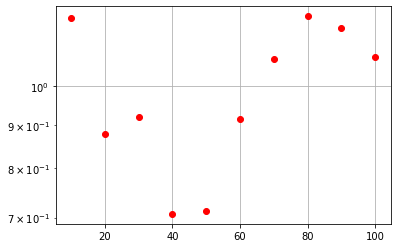

In [50]:
plt.figure(2)
psi=np.array(psi).astype('float64')


for i in range(len(psi)):
        y=np.mean([history0[f'sigma_val_psi{psi[i]}'][-1],history1[f'sigma_val_psi{psi[i]}'][-1],history2[f'sigma_val_psi{psi[i]}'][-1],history3[f'sigma_val_psi{psi[i]}'][-1],history4[f'sigma_val_psi{psi[i]}'][-1],history5[f'sigma_val_psi{psi[i]}'][-1],history6[f'sigma_val_psi{psi[i]}'][-1],history7[f'sigma_val_psi{psi[i]}'][-1],history8[f'sigma_val_psi{psi[i]}'][-1],history9[f'sigma_val_psi{psi[i]}'][-1]])
        x=(psi[i])
        plt.grid('True')
        plt.yscale('log')
        plt.plot(x,y,'ro')

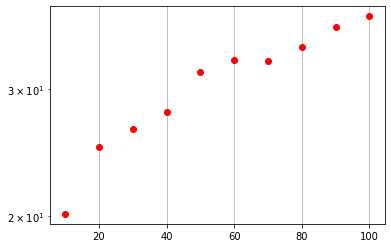

In [51]:
plt.figure(2)
psi=np.array(psi).astype('float64')


for i in range(len(psi)):
        y=history8[f'kahler_val_psi{psi[i]}'][-1]
        x=(psi[i])
        plt.grid('True')
        plt.yscale('log')
        plt.plot(x,y,'ro')

In [52]:
plt.figure(3)
psi=np.array(psi).astype('float64')
x=[]
y=[]
for i in range(len(psi)):
        y=np.mean([history0[f'kahler_val_psi{psi[i]}'][-1],history1[f'kahler_val_psi{psi[i]}'][-1],history2[f'kahler_val_psi{psi[i]}'][-1],history3[f'kahler_val_psi{psi[i]}'][-1],history4[f'kahler_val_psi{psi[i]}'][-1],history5[f'kahler_val_psi{psi[i]}'][-1],history6[f'kahler_val_psi{psi[i]}'][-1],history7[f'kahler_val_psi{psi[i]}'][-1],history8[f'kahler_val_psi{psi[i]}'][-1],history9[f'kahler_val_psi{psi[i]}'][-1]])
        x=(psi[i])
        plt.grid('True')
        plt.yscale('log')
        plt.plot(x,y,'ro')

In [53]:
plt.figure(4)
psi=np.array(psi).astype('float64')
x=[]
y=[]
for i in range(len(psi)):
        y=np.mean([history0[f'ricci_val_psi{psi[i]}'][-1],history1[f'ricci_val_psi{psi[i]}'][-1],history2[f'ricci_val_psi{psi[i]}'][-1],history3[f'ricci_val_psi{psi[i]}'][-1],history4[f'ricci_val_psi{psi[i]}'][-1],history5[f'ricci_val_psi{psi[i]}'][-1],history6[f'ricci_val_psi{psi[i]}'][-1],history7[f'ricci_val_psi{psi[i]}'][-1],history8[f'ricci_val_psi{psi[i]}'][-1],history9[f'ricci_val_psi{psi[i]}'][-1]])
        x=(psi[i])
        plt.grid('True')
        plt.yscale('log')
        plt.plot(x,y,'ro')

C:\Users\Álvaro\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [5]:
model = tfk.models.load_model('model3')

In [6]:
to_hermitian_batch(model(x_test))

NameError: name 'x_test' is not defined

In [7]:
psi2=[35,75,85,120,140,160,180]
ntrainpoints=100000
ntestpoints=1
trainomega=[]
testomega=[]
trainweight=[]
testweight=[]
realtest=[]
realtrain=[]
for i in range(len(psi)):
    trainpoints=quintic_monomial_points(ntrainpoints,psi[i])[:,:,1]
    trainpoints=np.divide(trainpoints,trainpoints[np.arange(len(trainpoints)),np.argmax(np.abs(trainpoints),axis=-1)].reshape(-1,1))
    testpoints=quintic_monomial_points(ntestpoints,psi[i])[:,:,1]
    testpoints=np.divide(testpoints,testpoints[np.arange(len(testpoints)),np.argmax(np.abs(testpoints),axis=-1)].reshape(-1,1))
    trainomega+=np.real(Omega_psi(trainpoints,psi[i])*np.conjugate(Omega_psi(trainpoints,psi[i]))).tolist()
    testomega+=np.real(Omega_psi(testpoints,psi[i])*np.conjugate(Omega_psi(testpoints,psi[i]))).tolist()
    trainweight+=np.real(weightsMono(trainpoints,psi[i])).tolist()
    testweight+=weightsMono(testpoints,psi[i]).tolist()
    realtrain+=np.concatenate((trainpoints,psi[i]*np.ones(np.shape(trainpoints)[0]).reshape((-1,1))),axis=-1).tolist()
    realtest+=np.concatenate((testpoints,psi[i]*np.ones(np.shape(testpoints)[0]).reshape(-1,1)),axis=-1).tolist()
realtrain=np.array(realtrain)
realtest=np.array(realtest)
trainomega=np.array(trainomega)
trainweight=np.array(trainweight)
testomega=np.array(testomega)
testweight=np.array(testweight)

x_eval=np.concatenate((np.real(realtrain[:,:-1]),np.imag(realtrain[:,:-1]),np.real(realtrain[:,-1].reshape(-1,1))),axis=-1).astype('float64')

predictmodel=to_hermitian_batch(model.predict(x_eval)).numpy()
pullback=JacobianMatrixFermat(x_eval[:,:5]+1j*x_eval[:,5:10])


In [8]:
sigma=np.zeros(np.shape(psi2))
kahler=np.zeros(np.shape(psi2))
ricci=np.zeros(np.shape(psi2))
s=ntrainpoints
for i in range(len(psi2)):
    sigma[i]=sigma_measure(trainweight[i*s:(i+1)*s],trainomega[i*s:(i+1)*s],predictmodel[i*s:(i+1)*s])
    kahler[i]=np.mean(kahler_loss(model,x_eval[i*s:(i+1)*s],pullback[i*s:(i+1)*s]).numpy())
    ricci[i]=Ricci_measure(model,x_eval[i*s:(i+1)*s],pullback[i*s:(i+1)*s],trainweight[i*s:(i+1)*s],trainomega[i*s:(i+1)*s])

C:\Users\Álvaro\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:160: ComplexWarning: Casting complex values to real discards the imaginary part
  ret = umr_sum(arr, axis, dtype, out, keepdims)
ipykernel_launcher:8: ComplexWarning: Casting complex values to real discards the imaginary part


In [13]:
plt.figure(2)
psi=np.array(psi).astype('float64')


for i in range(len(psi)):
        y=lasthistory[f'sigma_val_psi{psi[i]}'][-1]
        x=(psi[i])
        plt.grid('True')
        plt.yscale('log')
        plt.plot(x,y,'ro')
plt.plot(psi2,sigma,'bo')

In [14]:
plt.figure(3)
psi=np.array(psi).astype('float64')
x=[]
y=[]
for i in range(len(psi)):
        y=lasthistory[f'kahler_val_psi{psi[i]}'][-1]
        x=(psi[i])
        plt.grid('True')
        plt.yscale('log')
        plt.plot(x,y,'ro')
plt.plot(psi2,kahler,'bo')

In [15]:
plt.figure(4)
psi=np.array(psi).astype('float64')
x=[]
y=[]
for i in range(len(psi)):
        y=lasthistory[f'ricci_val_psi{psi[i]}'][-1]
        x=(psi[i])
        plt.grid('True')
        plt.yscale('log')
        plt.plot(x,y,'ro')
plt.plot(psi2,ricci,'bo')

C:\Users\Álvaro\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [16]:
print(ricci)

[-2.18501927e+05 -1.59545681e+03 -3.00656378e+04 -3.72784156e+02
 -7.32664507e+06 -3.43523308e+03 -1.45317629e+03]


In [ ]:
#Histogram rates